# <font color="blue">IMPORT </font>



In [ ]:
%load_ext autoreload
%autoreload 2
import sys; sys.path
sys.path.append("/content/drive/MyDrive/Artia on essecdrive")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from IPython import display

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers
from tensorflow import keras
import matplotlib.pyplot as plt
import time
import os

from artia.data import load_data,augment_data
from artia.model_build import compute_loss_divergence,compute_loss_reconstruct,Sampling
from artia.model_build import generate_and_save_images
from artia.utils import plot_history,plot_in_vs_out,generate_random_image, get_latest_model_path



#  <font color="blue">LOAD DATA</font> 

In [ ]:
path = "/content/drive/MyDrive/Artia on essecdrive/dataset/"
IMG_SIZE=180
batch_size=4

train_ds,val_ds=load_data(path)

#augmented data
train_ds_augmented=train_ds.concatenate(augment_data(train_ds))
train_ds_augmented=train_ds_augmented.concatenate(augment_data(train_ds))
train_ds_augmented=train_ds_augmented.concatenate(augment_data(train_ds))
train_ds_augmented=train_ds_augmented.concatenate(augment_data(train_ds))
train_ds=train_ds_augmented

Found 103 files belonging to 1 classes.
Using 83 files for training.
Found 103 files belonging to 1 classes.
Using 20 files for validation.


#  <font color="Blue">BUILD MODEL</font> 

In [ ]:
class Sampling(layers.Layer):
  def call(self,z_mean,z_log_var):
    noise = tf.random.normal(shape=tf.shape(z_mean))
    return z_mean + tf.exp(0.5 * z_log_var) * noise

In [ ]:
# Encoder
def init_encoder(latent_dim):
  encoder_input=keras.Input(shape=(180, 180, 3))
  rescaled_input=layers.Rescaling(scale=1./255.)(encoder_input)
  x=layers.Conv2D(32, kernel_size=(3), activation='relu', strides=(2,2) ,padding='same')(rescaled_input)
  x=layers.Conv2D(64, kernel_size=(3), activation='relu', strides=(2,2) ,padding='same')(x)
  x=layers.Flatten()(x)
  x=layers.Dense(300, activation='relu')(x)
  z_mean = layers.Dense(latent_dim, name="z_mean")(x)
  z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
  z=Sampling()(z_mean, z_log_var)
  return keras.Model(encoder_input, [z_mean, z_log_var, z])

In [ ]:
# Decoder
def init_decoder(latent_dim):  
  decoder_input=keras.Input(shape=(latent_dim,))
  x=layers.Dense(300, activation="relu")(decoder_input)
  x=layers.Dense(45 * 45 * 64, activation="relu")(x)
  x=layers.Reshape((45, 45, 64))(x)
  x=layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
  x=layers.Conv2DTranspose(3, 3, activation="sigmoid", strides=2, padding="same")(x)
  rescaled_x=layers.Rescaling(scale=255.)(x)
  return keras.Model(decoder_input, rescaled_x)

In [ ]:
class VAE(tf.Module):
  def __init__(self, encoder, decoder, **kwargs):
    super(VAE, self).__init__(**kwargs)
    self.encoder=encoder
    self.decoder=decoder
    self.optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001)
    self.loss_tracker = keras.metrics.Mean(name="loss")
    self.loss_reconstruct_tracker = keras.metrics.Mean(name="reconstruction_loss")
    self.loss_divergence_tracker = keras.metrics.Mean(name="divergence_loss")
    self.output_r=tf.Variable(1., shape=tf.TensorShape(None))
    
  @tf.function # This annotation causes the function to be "compiled".
  def train_step(self, images):
    with tf.GradientTape() as tape:
      output_mean, output_logvar, output_z = self.encoder(images)
      output_reconstruct = self.decoder(output_z)
      self.output_r.assign(output_reconstruct)
      reconstruction_loss=(compute_loss_reconstruct(images, output_reconstruct))
      divergence_loss=(compute_loss_divergence(output_logvar, output_mean))
      loss = tf.add(reconstruction_loss*100,divergence_loss*100)
    gradients = tape.gradient(loss, self.trainable_variables)
    self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
    self.loss_tracker.update_state(loss)
    self.loss_reconstruct_tracker.update_state(reconstruction_loss)
    self.loss_divergence_tracker.update_state(divergence_loss)
    return {"loss": self.loss_tracker.result(),
            "reconstruction_loss": self.loss_reconstruct_tracker.result(),
            "divergence_loss": self.loss_divergence_tracker.result()}

#  <font color="blue">TRAIN CUSTOM</font> 

In [ ]:
# LOAD DATA
train_dataset = train_ds
EPOCH = 300

# Define Model Architecture
latent_dim=64
model = VAE(init_encoder(latent_dim), init_decoder(latent_dim))

# Checkpoints
checkpoint_dir = '/content/drive/MyDrive/Artia on essecdrive/outputdata_laure/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(model = model)

# Train methods
def train(dataset, val, epochs):
  hist_loss=[]
  hist_loss_reconstruct=[]
  hist_loss_divergence=[]
  for epoch in range(epochs):
    start = time.time()
    for images_batch in dataset:
      model.train_step(images_batch)
    # Save the model every 15 epochs
    if (epoch + 1) % 5 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
      plt.figure(figsize=(15,10))
      plt.subplot(1,2,1)
      plt.imshow(images_batch[0]/255)
      plt.subplot(1,2,2)
      plt.imshow(model.output_r[0]/255)
      plt.show()
    hist_loss.append(model.loss_tracker.result())
    hist_loss_reconstruct.append(float(model.loss_reconstruct_tracker.result()))
    hist_loss_divergence.append(float(round(model.loss_divergence_tracker.result().numpy(),2)))
    print (f'Epoch {epoch + 1} : {round(time.time()-start,2)} sec -- loss = {model.loss_tracker.result()} -- reconstruction_loss = {model.loss_reconstruct_tracker.result()} -- divergence_loss = {round(model.loss_divergence_tracker.result().numpy(),2)}')
  return dict(zip(['hist_loss','hist_loss_reconstruct', 'hist_loss_divergence'], [hist_loss,hist_loss_reconstruct, hist_loss_divergence]))
  
# Train
history = train(train_dataset,val_ds, EPOCH)

# Restore Model weights if needed
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))


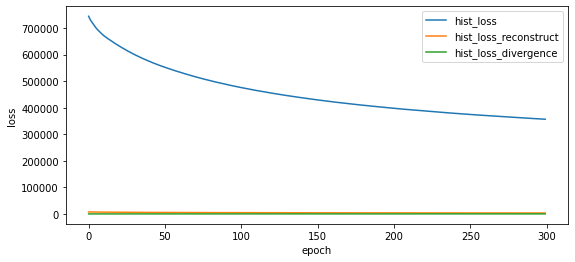

In [ ]:
plot_history(history);

#  <font color="blue">RESULT</font>

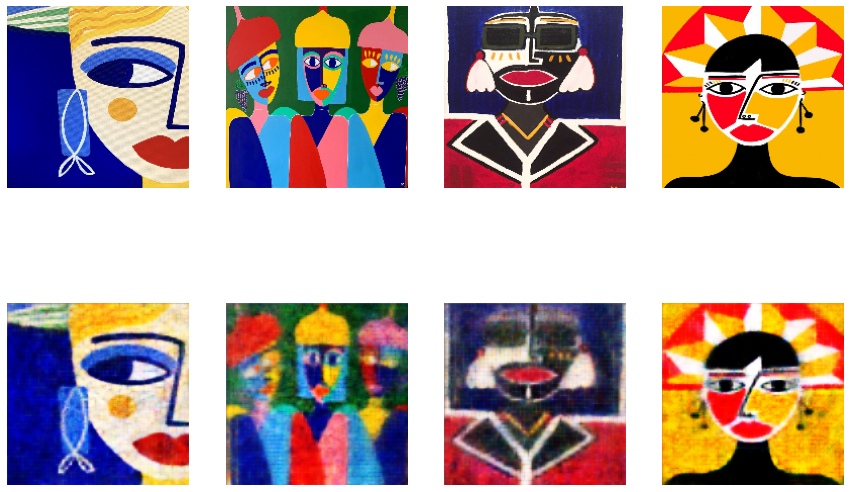

In [ ]:
plot_in_vs_out(model,train_ds)

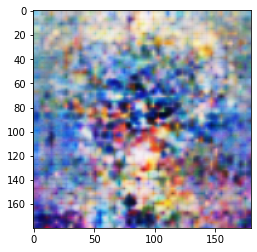

In [ ]:
generate_random_image(model,latent_dim);